In [1]:
import pypose as pp
import torch
from perseus.smoother.base import FixedLagSmootherConfig, FixedLagSmoother
import kornia
import json
%load_ext autoreload
%autoreload 2

In [2]:
smoother = FixedLagSmoother()
smoother.prior_pose_mean = pp.randn_SE3()
smoother.prior_vel_mean = pp.randn_se3()

In [3]:
optimizer = pp.optim.GN(smoother)
weights = [torch.linalg.inv(smoother.prior_pose_covariance), torch.linalg.inv(smoother.prior_vel_covariance), torch.linalg.inv(smoother.cfg.Q_pose), torch.linalg.inv(smoother.cfg.Q_vel)]
for ii in range(1):
    %timeit optimizer.step({"input": torch.zeros(5)}, weight=weights)

smoother.poses[0].Exp(), smoother.prior_pose_mean

TypeError: FixedLagSmoother.forward() got an unexpected keyword argument 'input'

In [48]:
# Load train dataset.
from perseus.detector.data import KeypointDataset, KeypointDatasetConfig
dataset = KeypointDataset(KeypointDatasetConfig(), train=False)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)


Images shape: (11559, 256, 256, 3)


In [56]:
# Load image and keypoints.
data = dataset[:1]
image = data["image"]
object_pose = data["object_pose"]
keypoints = data["pixel_coordinates"]
camera_pose = data["camera_pose"]
object_scale = data["object_scale"]
camera_intrinsics = data["camera_intrinsics"]
image_filename = data["image_filename"][0].astype("str")
print(image_filename)

# Load keypoint detector.
from perseus.detector.models import KeypointCNN
detector = KeypointCNN()
detector.load_state_dict(torch.load("outputs/models/fbz72ad3.pth"))
detector.eval()

# Detect keypoints.
pred_keypoints = detector(image)[0].reshape(-1, 2)
pred_keypoints = kornia.geometry.denormalize_pixel_coordinates(pred_keypoints, *image.shape[2:])

# Compute keypoint locations in camera frame.
keypoints_object_frame = torch.tensor(json.load(open("data/2024-01-12_17-21-39/mjc_keypoints.json"))).float() * object_scale
keypoints_world_frame = object_pose[0].Act(keypoints_object_frame)

data/2024-01-12_17-21-39/860855fc-b4cf-49fc-a32e-03a0733fa0a1/rgba_00009.png


In [57]:
import json
from pathlib import Path
metadata_path = Path(image_filename).parent / "metadata.json"
with open(metadata_path) as f:
    metadata = json.load(f)

image_index = int(Path(image_filename).stem.split("_")[-1])

# Load ground truth object COM location.
object_dict = [ii for ii in metadata["instances"] if ii["asset_id"] == "mjc"][0]
object_com = torch.tensor(object_dict["image_positions"][image_index]).float()

object_com = 2 * object_com - 1 # Scale to [-1, 1] range.
object_com_pixel = kornia.geometry.denormalize_pixel_coordinates(object_com, *image.shape[2:])
object_com_pixel


tensor([ 49.8802, 118.4123])

In [59]:
intrinsics_kubric = metadata["camera"]["K"]
intrinsics = torch.zeros(4,4)
intrinsics[:3, :3] = torch.tensor(intrinsics_kubric)
extrinsics = (camera_pose[0].Inv() @ object_pose[0]).matrix()

# Compute raw point:
point_homogenous = torch.diag(torch.tensor([256, 256, 1, 0])).float() @ intrinsics @ extrinsics @ torch.tensor([0, 0, 0, 1]).float()
com_image = point_homogenous[:2] / point_homogenous[2]

com_image, #com_image_pixel

# com_image = 2 * com_image - 1 # Scale to [-1, 1] range.
# com_image_pixel = kornia.geometry.denormalize_pixel_coordinates(com_image, *image.shape[2:])

(tensor([ 50.0758, 118.8767]),)

In [60]:
cube_com_camera_frame = (camera_pose.Inv() @ object_pose).translation()
camera_intrinsics_modified = torch.diag(torch.tensor([256., 256., 1.])) @ torch.tensor(intrinsics_kubric)

print(cube_com_camera_frame)

keypoints_camera_frame = camera_pose.Inv().Act(keypoints_world_frame)

print(keypoints_camera_frame)

print(keypoints_camera_frame.shape, camera_intrinsics_modified.shape, keypoints_world_frame.shape, camera_pose.shape)


pypose_keypoints = pp.point2pixel(keypoints_world_frame, camera_intrinsics_modified, camera_pose[0].Inv())
# pypose_keypoints = pp.point2pixel(cube_com_camera_frame, camera_intrinsics_modified)
# pypose_keypoints = pp.point2pixel(torch.tensor([[-1, -1, -6.]]), camera_intrinsics_modified)
# camera_intrinsics_modified

cube_com_camera_frame, object_pose.translation()
pypose_keypoints

# pypose_keypoints
# camera_extrinsics.Inv().Act(keypoints_world_frame)
# camera_extrinsics.Inv() @ keypoints_world_frame

# camera_intrinsics_modified

# # keypoints_world_frame
# camera_extrinsics.translation(), keypoints_world_frame, object_pose.translation()

tensor([[-1.9144,  0.2241, -6.8789]])
tensor([[-2.3028,  0.1638, -8.5079],
        [-0.6025, -0.3565, -7.7448],
        [-3.2264, -0.7940, -7.1029],
        [-1.5260, -1.3143, -6.3399],
        [-2.3028,  1.7625, -7.4179],
        [-0.6025,  1.2423, -6.6549],
        [-3.2263,  0.8048, -6.0130],
        [-1.5260,  0.2845, -5.2499]])
torch.Size([8, 3]) torch.Size([3, 3]) torch.Size([8, 3]) torch.Size([1, 7])


tensor([[ 52.2126, 122.6106],
        [106.2179, 140.8884],
        [  0.8162, 159.2997],
        [ 60.6031, 186.0437],
        [ 41.0785,  61.4710],
        [102.6522,  75.7319],
        [-22.2356,  90.5255],
        [ 46.6131, 112.8257]])

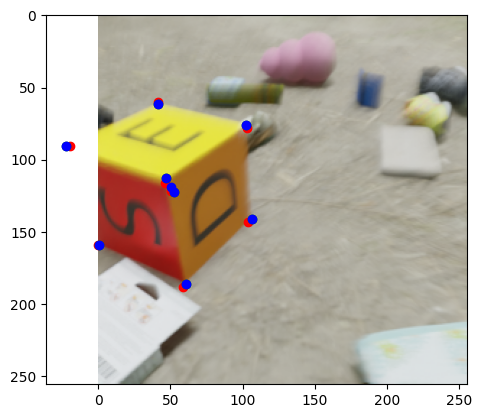

In [61]:
from matplotlib import pyplot as plt
plt.imshow(image[0].permute(1, 2, 0))
plt.scatter(pred_keypoints[:, 0].detach(), pred_keypoints[:, 1].detach(), c="r")
# keypoints = kornia.geometry.denormalize_pixel_coordinates(keypoints[0], *image.shape[2:])
plt.scatter(keypoints[0, :, 0], keypoints[0, :, 1], c="g")
# plt.scatter(*object_com_pixel, c="r")
plt.scatter(*com_image, c="b")
plt.scatter(pypose_keypoints[:, 0].detach(), pypose_keypoints[:, 1].detach(), c="b")

In [138]:
pp.reprojerr(keypoints_world_frame, pred_keypoints, camera_intrinsics_modified, camera_pose[0].Inv())

tensor([[ 1.8401,  1.1611],
        [ 2.1496, -2.1678],
        [ 0.9929,  0.3694],
        [ 1.8124, -2.1037],
        [-0.5140,  1.5275],
        [-0.7235, -2.0122],
        [-2.5916, -0.2314],
        [ 0.1436, -3.4362]], grad_fn=<SubBackward0>)

In [7]:
# Test full smoother on a given dataset.
from perseus.smoother.base import FixedLagSmootherConfig, FixedLagSmoother, smoother_config_from_dataset
from pathlib import Path
from PIL import Image
import numpy as np
from data_generation.data_utils import reorder_quaternion
%load_ext autoreload
%autoreload 2

dataset_path = "data/2024-01-12_17-21-39/01ba8350-8110-47e2-ac2c-239882986936/"
metadata = json.load(open(Path(dataset_path) / "metadata.json"))

smoother_cfg = smoother_config_from_dataset(dataset_path, horizon=10)

smoother = FixedLagSmoother(smoother_cfg)
device = "cpu"

# Load images from this trajectory.
image_files = sorted([ii for ii in Path(dataset_path).glob("rgba*.png")])
image_list = []
for ii in image_files:
    image_list.append(kornia.utils.image_to_tensor(np.array(Image.open(ii).convert("RGB"))) / 255.0)
images = torch.stack(image_list)

# Compute object poses.
object_dict = [ii for ii in metadata["instances"] if ii["asset_id"] == "mjc"][0]
object_positions = torch.tensor(object_dict["positions"]).float()
object_quaternions = reorder_quaternion(torch.tensor(object_dict["quaternions"]).float())
camera_pose = pp.mat2SE3(torch.tensor(metadata["camera"]["R"]))
gt_object_poses = camera_pose.Inv() @ pp.SE3(torch.cat([object_positions, object_quaternions], dim=-1))
gt_keypoint_positions = gt_object_poses.unsqueeze(1).Act(smoother.cfg.keypoints.unsqueeze(0))
gt_keypoint_coordinates = pp.point2pixel(gt_keypoint_positions, smoother.cfg.camera_intrinsics)

# Load keypoint detector.
from perseus.detector.models import KeypointCNN
detector = KeypointCNN()
detector.eval()
detector.load_state_dict(torch.load(smoother_cfg.detector_model_path))

# Detect keypoints.
pred_keypoints = detector(images).reshape(-1, 8, 2)
pred_keypoints = kornia.geometry.denormalize_pixel_coordinates(pred_keypoints, *images.shape[2:]).reshape(-1, 8, 2)
smoother = smoother.to("cuda")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Check smoother "forward" method works.
smoother(pred_keypoints[:10].to("cuda"))

(se3Type LieTensor:
 LieTensor([0., 0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<AliasBackward0>),
 tensor([0., 0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SubBackward0>),
 se3Type LieTensor:
 LieTensor([[0., 0., 0., 0., 0., 0.],
            [0., 0., 0., 0., 0., 0.],
            [0., 0., 0., 0., 0., 0.],
            [0., 0., 0., 0., 0., 0.],
            [0., 0., 0., 0., 0., 0.],
            [0., 0., 0., 0., 0., 0.],
            [0., 0., 0., 0., 0., 0.],
            [0., 0., 0., 0., 0., 0.],
            [0., 0., 0., 0., 0., 0.],
            [0., 0., 0., 0., 0., 0.]], device='cuda:0',
           grad_fn=<AliasBackward0>),
 tensor([[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]], device='cuda:0',

In [19]:
# Run smoother. 
optimizer = pp.optim.GN(smoother)
weights = [torch.linalg.inv(smoother.prior_pose_covariance), torch.linalg.inv(smoother.prior_vel_covariance), torch.linalg.inv(smoother.cfg.Q_pose), torch.linalg.inv(smoother.cfg.Q_vel), torch.linalg.inv(smoother.cfg.R_keypoints)]
weights = [ww.to("cuda") for ww in weights]
pred_keypoints = pred_keypoints.to("cuda")
for ii in range(10):
    %time optimizer.step({"pixel_coordinates": pred_keypoints[:10]}, weight=weights)

# step_compiled = torch.compile(optimizer.step)
# step_compiled({"pixel_coordinates": pred_keypoints[:10]}, weight=weights)

CPU times: user 101 ms, sys: 257 µs, total: 102 ms
Wall time: 101 ms
CPU times: user 89.3 ms, sys: 243 µs, total: 89.5 ms
Wall time: 89.5 ms
CPU times: user 89.5 ms, sys: 0 ns, total: 89.5 ms
Wall time: 89.5 ms
CPU times: user 90.6 ms, sys: 61 µs, total: 90.6 ms
Wall time: 89.9 ms
CPU times: user 91.1 ms, sys: 0 ns, total: 91.1 ms
Wall time: 91 ms
CPU times: user 91 ms, sys: 0 ns, total: 91 ms
Wall time: 90.9 ms
CPU times: user 91.9 ms, sys: 0 ns, total: 91.9 ms
Wall time: 91.7 ms
CPU times: user 90 ms, sys: 143 µs, total: 90.2 ms
Wall time: 90.1 ms
CPU times: user 85 ms, sys: 3.39 ms, total: 88.4 ms
Wall time: 88.4 ms
CPU times: user 89.2 ms, sys: 218 µs, total: 89.4 ms
Wall time: 88.8 ms


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument other in method wrapper_CUDA_linalg_cross)

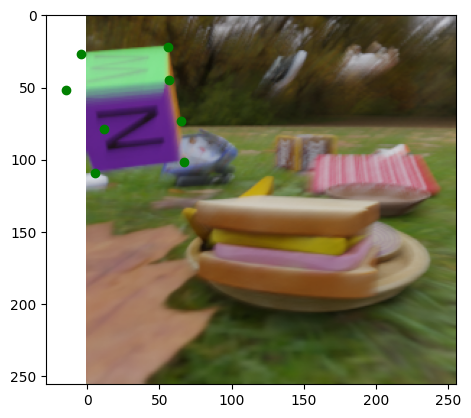

In [20]:
# Visualize results.
from matplotlib import pyplot as plt
img_idx = 2
# Show image.
plt.imshow(images[img_idx].permute(1, 2, 0))

# Plot measurement in red.
# plt.scatter(pred_keypoints[img_idx, :, 0].detach(), pred_keypoints[img_idx, :, 1].detach(), c="r")

# Plot ground truth in green.
plt.scatter(gt_keypoint_coordinates[img_idx, :, 0], gt_keypoint_coordinates[img_idx, :, 1], c="g")

# Compute and plot smoothed estimate in blue.
est_keypoints = pp.point2pixel(smoother.poses[img_idx].Exp().Act(smoother.cfg.keypoints), smoother.cfg.camera_intrinsics).detach()

plt.scatter(est_keypoints[:, 0], est_keypoints[:, 1], c="b")
plt.show()


In [124]:
orig_keypoints = kornia.geometry.denormalize_pixel_coordinates(detector(image).reshape(-1, 8, 2), *image.shape[2:])
pred_keypoints = kornia.geometry.denormalize_pixel_coordinates(detector(images[:10]).reshape(-1, 8, 2), *image.shape[2:])[9]

# orig_keypoints - pred_keypoints
# detector(images[9:10]) -  detector(image)


(tensor([-0.6049, -0.0475, -0.1838,  0.1220, -1.0014,  0.2465, -0.5389,  0.4757,
         -0.6738, -0.5299, -0.1892, -0.3902, -1.1541, -0.2882, -0.6355, -0.0881],
        grad_fn=<SelectBackward0>),
 tensor([[-0.6049, -0.0475, -0.1838,  0.1220, -1.0014,  0.2465, -0.5389,  0.4757,
          -0.6738, -0.5299, -0.1892, -0.3902, -1.1541, -0.2882, -0.6355, -0.0881],
         [-0.5988, -0.0519, -0.1833,  0.1077, -0.9938,  0.2471, -0.5434,  0.4655,
          -0.6745, -0.5315, -0.1986, -0.4051, -1.1581, -0.2839, -0.6576, -0.0982],
         [-0.6067, -0.0479, -0.1856,  0.1180, -0.9988,  0.2462, -0.5360,  0.4720,
          -0.6740, -0.5291, -0.1922, -0.3940, -1.1518, -0.2869, -0.6361, -0.0933],
         [-0.6049, -0.0475, -0.1838,  0.1220, -1.0014,  0.2465, -0.5389,  0.4757,
          -0.6738, -0.5299, -0.1892, -0.3902, -1.1541, -0.2882, -0.6355, -0.0881]],
        grad_fn=<AddmmBackward0>))